In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

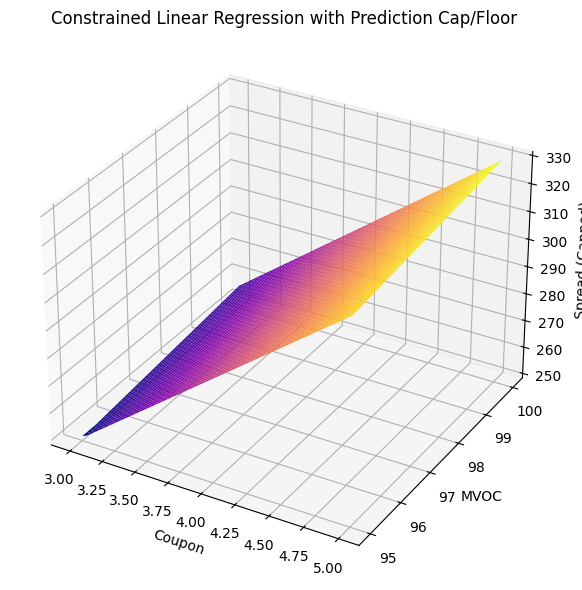

In [3]:
from scipy.optimize import minimize

# Example data
df = pd.DataFrame({
    "coupon": [3.0, 3.5, 4.0, 4.5, 5.0],
    "mvoc":   [95, 97, 98, 99, 100],
    "spread": [250, 270, 290, 310, 330]
})

X = df[["coupon", "mvoc"]].values
y = df["spread"].values

# Add intercept
X_design = np.hstack([np.ones((X.shape[0], 1)), X])  # [1, coupon, mvoc]

# Objective function: minimize squared error
def loss_fn(beta):
    pred = X_design @ beta
    return np.mean((pred - y) ** 2)

# Initial guess
beta0 = np.array([0, 1, 1])

# Constraints: beta[1] >= 0, beta[2] >= 0
bounds = [(None, None), (0, None), (0, None)]

# Fit the model
result = minimize(loss_fn, beta0, bounds=bounds)

# Fitted parameters
beta_fit = result.x

# Predict function with cap and floor
def predict_constrained(X_new, beta, floor=250, cap=400):
    X_new_design = np.hstack([np.ones((X_new.shape[0], 1)), X_new])
    preds = X_new_design @ beta
    return np.clip(preds, floor, cap)

# Generate surface
coupon_grid = np.linspace(3.0, 5.0, 50)
mvoc_grid = np.linspace(95, 100, 50)
C, M = np.meshgrid(coupon_grid, mvoc_grid)
X_new = np.column_stack([C.ravel(), M.ravel()])
S = predict_constrained(X_new, beta_fit, floor=250, cap=400).reshape(C.shape)

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(C, M, S, cmap="plasma", edgecolor="none")
ax.set_xlabel("Coupon")
ax.set_ylabel("MVOC")
ax.set_zlabel("Spread (Capped)")
ax.set_title("Constrained Linear Regression with Prediction Cap/Floor")
plt.tight_layout()
plt.show()


In [7]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


            Model        R2          RMSE
0  Multiplicative  0.574791  74785.827756
1          Linear  0.552726  76701.676485
2   Decision Tree  0.611384  71495.433522


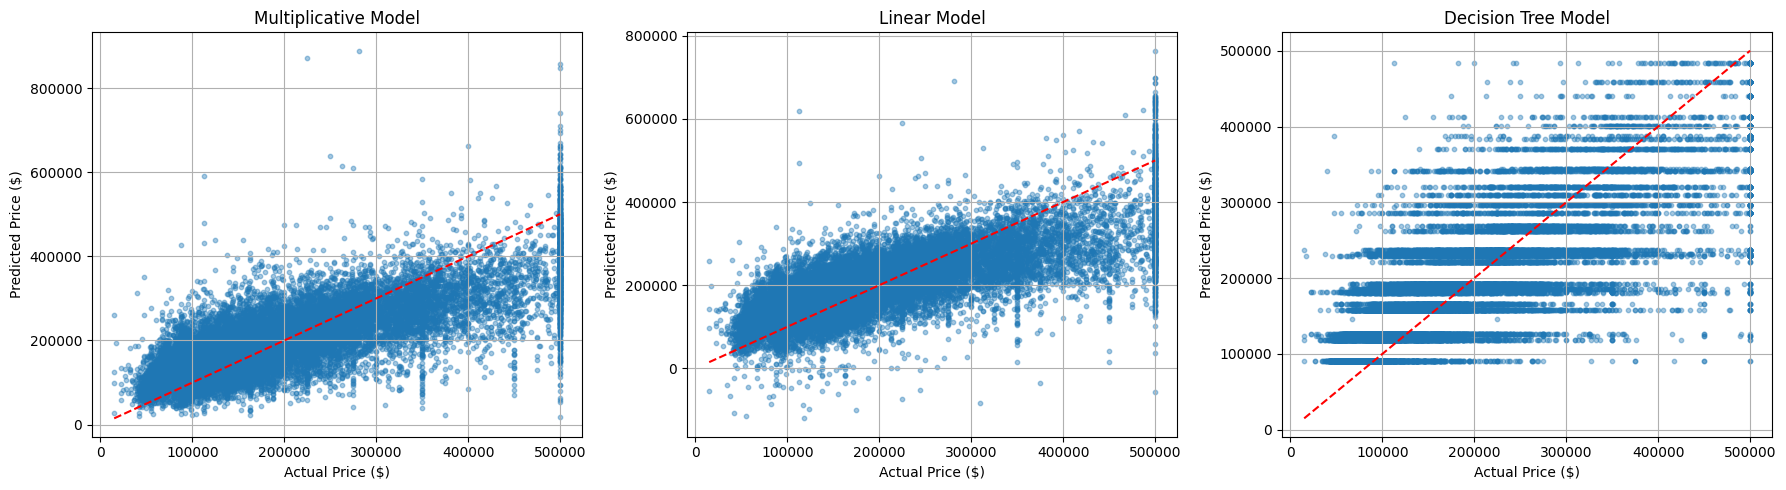

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit

# Load California housing data
data = fetch_california_housing(as_frame=True)
df = data.frame

# Select relevant features and target
features = ['MedInc', 'AveRooms', 'AveOccup']
X = df[features]
y = df['MedHouseVal'] * 100000  # Convert to dollars

# Remove outliers for clearer modeling
mask = (X['MedInc'] < 15) & (X['AveRooms'] < 20) & (X['AveOccup'] < 10)
X = X[mask]
y = y[mask]

# Multiplicative model: y = a * x1^b1 * x2^b2 * x3^b3
def multiplicative_model(X_data, a, b1, b2, b3):
    x1, x2, x3 = X_data
    return a * x1**b1 * x2**b2 * x3**b3

# Fit multiplicative model using curve_fit
X_data = np.vstack([X[col].values for col in features])
params, _ = curve_fit(multiplicative_model, X_data, y, p0=[1, 1, 1, 1])
y_pred_mul = multiplicative_model(X_data, *params)

# Fit linear regression
lin_reg = LinearRegression().fit(X, y)
y_pred_lin = lin_reg.predict(X)

# Fit decision tree
tree = DecisionTreeRegressor(max_depth=5, random_state=0)
tree.fit(X, y)
y_pred_tree = tree.predict(X)

# Evaluate model performance
def evaluate(y_true, y_pred):
    return r2_score(y_true, y_pred), np.sqrt(mean_squared_error(y_true, y_pred))

results = {
    "Model": ["Multiplicative", "Linear", "Decision Tree"],
    "R2": [
        evaluate(y, y_pred_mul)[0],
        evaluate(y, y_pred_lin)[0],
        evaluate(y, y_pred_tree)[0]
    ],
    "RMSE": [
        evaluate(y, y_pred_mul)[1],
        evaluate(y, y_pred_lin)[1],
        evaluate(y, y_pred_tree)[1]
    ]
}

print(pd.DataFrame(results))

# Plot actual vs predicted
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
models = ["Multiplicative", "Linear", "Decision Tree"]
preds = [y_pred_mul, y_pred_lin, y_pred_tree]

for ax, model, pred in zip(axs, models, preds):
    ax.scatter(y, pred, alpha=0.4, s=10)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    ax.set_title(f"{model} Model")
    ax.set_xlabel("Actual Price ($)")
    ax.set_ylabel("Predicted Price ($)")
    ax.grid(True)

plt.tight_layout()
plt.show()


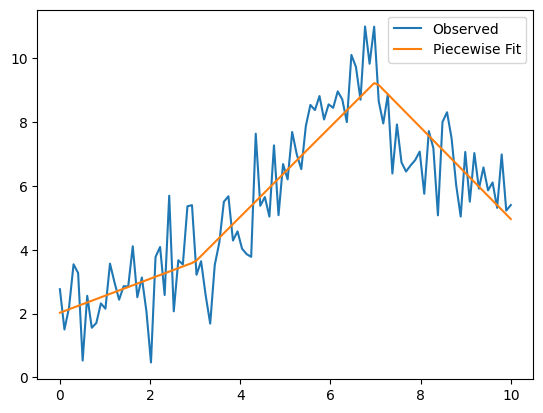

In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrix

# Simulated data
np.random.seed(0)
x = np.linspace(0, 10, 100)
y = np.piecewise(x, [x < 3, (x >= 3) & (x < 7), x >= 7], [lambda x: x + 1, lambda x: 2 * x - 3, lambda x: -x + 15])
y += np.random.normal(scale=1.0, size=len(x))
df = pd.DataFrame({'x': x, 'y': y})

# Create piecewise linear terms using splines
x_spline = dmatrix("bs(x, knots=(3,7), degree=1, include_intercept=False)", data=df, return_type='dataframe')

# Fit linear model
model = sm.OLS(df['y'], x_spline).fit()

# Predict
df['y_pred'] = model.predict(x_spline)

# Plot
import matplotlib.pyplot as plt
plt.plot(df['x'], df['y'], label='Observed')
plt.plot(df['x'], df['y_pred'], label='Piecewise Fit')
plt.legend()
plt.show()


<Axes: >

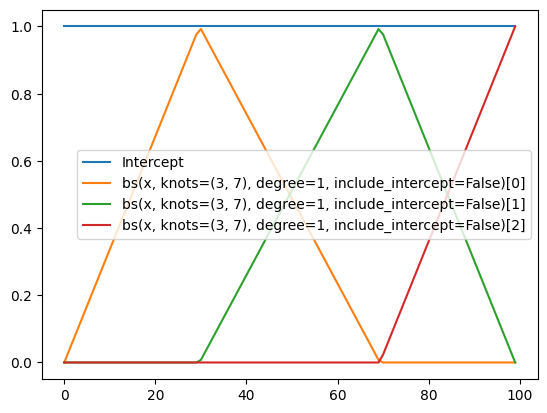

In [20]:
x_spline.plot()

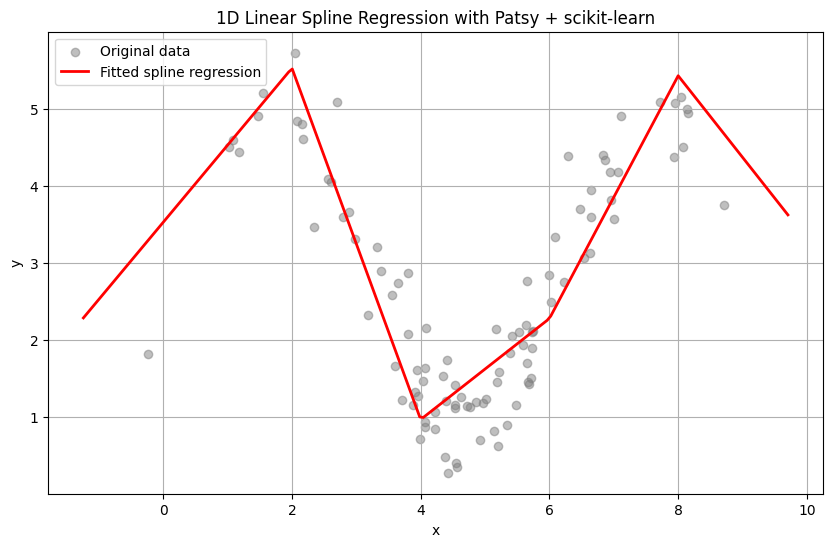

Spline Coefficients:
Basis 0: 0.0000
Basis 1: 3.2365
Basis 2: -1.3163
Basis 3: -0.0082
Basis 4: 3.1378
Basis 5: 1.3348


In [37]:
import numpy as np
import pandas as pd
from patsy import dmatrix
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 1. Generate random data
np.random.seed(42)
n_samples = 100
x = np.sort(np.random.normal(loc=5, scale=2, size=n_samples))
y = 3 + 2 * np.sin(x) + np.random.normal(scale=0.5, size=n_samples)

# 2. Create spline basis for x using patsy (linear splines, df=5)
x_df = pd.DataFrame({"x": x})
X_spline = dmatrix("bs(x, knots=(2,4,6,8), degree=1, include_intercept=False)", x_df)

# 3. Fit linear regression on spline basis
model = LinearRegression()
model.fit(X_spline, y)

# 4. Generate new x values (uniformly spaced)
x_new = np.linspace(x.min() - 1, x.max() + 1, 200)
x_new_df = pd.DataFrame({"x": x_new})
X_new_spline = dmatrix("bs(x, knots=(2,4,6,8), degree=1, include_intercept=False)", x_new_df)

# 5. Predict on new x
y_pred = model.predict(X_new_spline)

# 6. Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='gray', alpha=0.5, label="Original data")
plt.plot(x_new, y_pred, color='red', lw=2, label="Fitted spline regression")
plt.title("1D Linear Spline Regression with Patsy + scikit-learn")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# 7. Show coefficients
print("Spline Coefficients:")
for i, coef in enumerate(model.coef_):
    print(f"Basis {i}: {coef:.4f}")


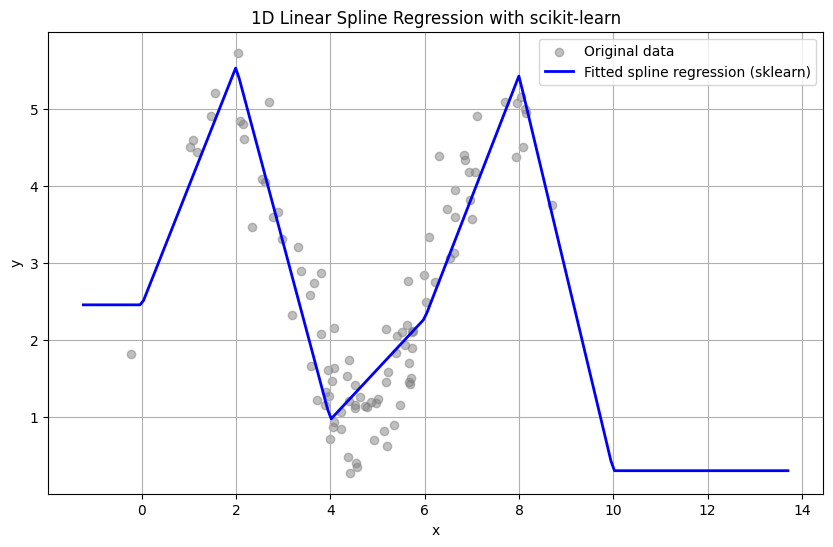

Spline Coefficients (sklearn):
Basis 0: 2.1487
Basis 1: 5.2317
Basis 2: 0.6608
Basis 3: 1.9719
Basis 4: 5.1168


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# 1. Generate random data
np.random.seed(42)
n_samples = 100
x = np.sort(np.random.normal(loc=5, scale=2, size=n_samples)).reshape(-1, 1)
y = 3 + 2 * np.sin(x).ravel() + np.random.normal(scale=0.5, size=n_samples)

# 2. Create SplineTransformer + LinearRegression pipeline
spline = SplineTransformer(degree=1, knots = np.array([0, 2, 4, 6, 8, 10]).reshape(-1, 1), include_bias=False, extrapolation='constant')
model = make_pipeline(spline, LinearRegression())

# 3. Fit the model
model.fit(x, y)

# 4. Generate uniform new x for prediction
x_new = np.linspace(x.min() - 1, x.max() + 5, 200).reshape(-1, 1)
y_pred = model.predict(x_new)

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='gray', alpha=0.5, label="Original data")
plt.plot(x_new, y_pred, color='blue', lw=2, label="Fitted spline regression (sklearn)")
plt.title("1D Linear Spline Regression with scikit-learn")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# 6. Show coefficients
coefs = model.named_steps['linearregression'].coef_
print("Spline Coefficients (sklearn):")
for i, coef in enumerate(coefs):
    print(f"Basis {i}: {coef:.4f}")


In [ ]:
spline.transform

In [66]:
model[1].coef_

array([2.14872785, 5.23170495, 0.66083896, 1.9719141 , 5.116761  ])

In [67]:
model[1].intercept_

np.float64(0.3093671735935888)

## Every combination of the basis functions is a continuous function.

In [171]:
spline = SplineTransformer(degree=1, knots = np.array([0, 2, 4, 6, 8, 10]).reshape(-1, 1), include_bias=False, extrapolation='constant')
x = np.linspace(-1, 11, 100).reshape(-1, 1)
y = np.sin(x) + np.random.normal(scale=0.1, size=x.shape)
spline.fit(x)
x_basis = spline.transform(x)

In [172]:
r = LinearRegression()
r.fit(x_basis, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [173]:
r.coef_

array([[ 0.53009582,  2.04092927, -0.33887512,  0.37067304,  2.09473498]])

In [107]:
betas = np.array( [1, 2, 3, 4, 5] ).reshape(1, -1)

In [174]:
r.coef_

array([[ 0.53009582,  2.04092927, -0.33887512,  0.37067304,  2.09473498]])

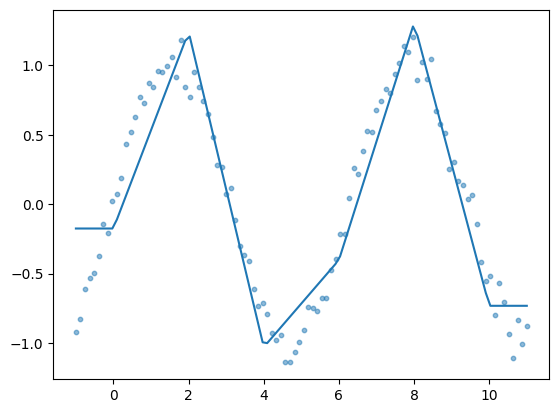

In [175]:
plt.plot( x, x_basis @ np.array([[ 0.55703942,  1.97507151, -0.2974766 ,  0.33007822,  2.0390433 ]]).T + r.intercept_)
plt.scatter(x, y, s=10, alpha=0.5)

In [176]:
from sklearn.preprocessing import KBinsDiscretizer

In [177]:
kbd = KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='uniform')
x_binned = kbd.fit_transform(x)

In [178]:
kbd_betas = np.array( [1, 2, 3, 4, 5] ).reshape(1, -1)
y_kbd = x_binned @ kbd_betas.T

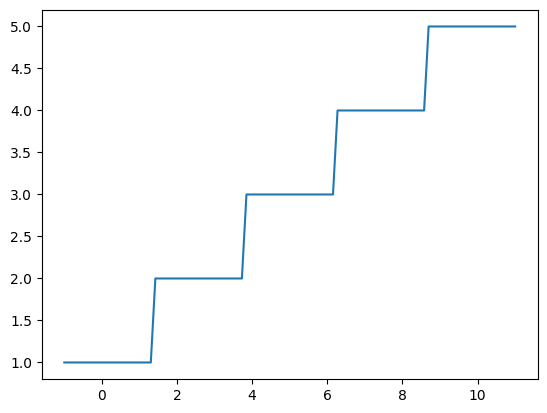

In [179]:
plt.plot( x.ravel(), x_binned @ kbd_betas.T.ravel() )

In [1]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class MonotonicStepUpTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, knots):
        self.knots = np.asarray(knots)
        if not np.all(np.diff(self.knots) > 0):
            raise ValueError("Knots must be strictly increasing.")
        self.n_steps = len(self.knots)

    def fit(self, X, y=None):
        return self  # stateless

    def transform(self, X):
        """
        Create cumulative indicator features: I(x >= a_j) for each knot a_j
        Shape: (n_samples, n_knots)
        """
        X = np.asarray(X).ravel()
        return np.array([(X >= k).astype(float) for k in self.knots]).T

    def predict(self, X, beta):
        """
        beta: shape (n_knots,)
        Returns: f(x) = sum I(x ≥ a_j) * β_j
        """
        basis = self.transform(X)
        return basis @ beta
    
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class MonotonicLinearRampTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, knots):
        self.knots = np.asarray(knots)
        if not np.all(np.diff(self.knots) > 0):
            raise ValueError("Knots must be strictly increasing.")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Creates basis: [1, x, max(0, x - t1), ..., max(0, x - tk)]
        """
        X = np.asarray(X).ravel()
        basis = [np.ones_like(X), X]
        for t in self.knots:
            basis.append(np.maximum(0, X - t))
        return np.vstack(basis).T  # shape (n_samples, n_features)

    def predict(self, X, beta):
        return self.transform(X) @ beta



In [2]:
import matplotlib.pyplot as plt

# Instantiate and fit transformer
step = MonotonicLinearRampTransformer(knots=[0, 2, 4, 6, 8, 10])
step.fit(x);


NameError: name 'x' is not defined

In [216]:
x_stepwise = step.transform(x)
r = LinearRegression()
r.fit(x_stepwise, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


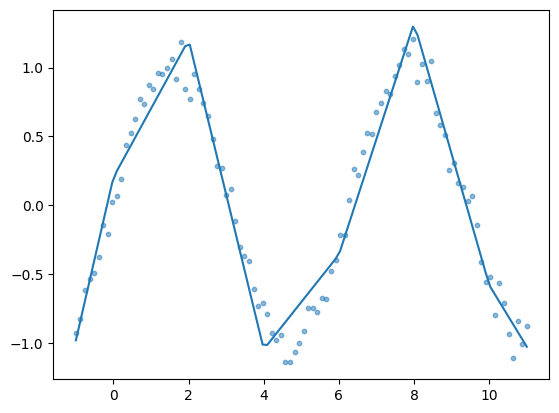

In [217]:
plt.plot( x, x_stepwise @ r.coef_.T + r.intercept_ )
plt.scatter(x, y, s=10, alpha=0.5)

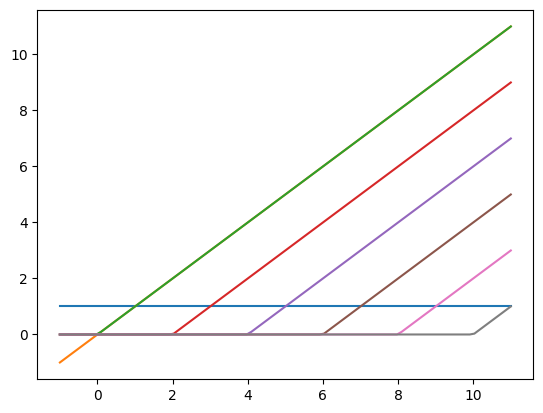

In [218]:
plt.plot(x, x_stepwise)

In [241]:
spline = SplineTransformer(degree=1, knots = np.array([0, 2, 4, 6, 8, 10]).reshape(-1, 1), include_bias=False, extrapolation='constant')

In [258]:
knots = np.array([
    [-2, -1, 0, 1],
    [ 0,  1, 2, 3],
    [ 2,  3, 4, 5],
])

In [259]:
x = np.random.normal( size=100 ).reshape(25, 4)
spline = SplineTransformer(degree=1, knots = knots, include_bias=False, extrapolation='constant')

In [261]:
print( spline.fit(x) )

SplineTransformer(degree=1, include_bias=False,
                  knots=array([[-2, -1,  0,  1],
       [ 0,  1,  2,  3],
       [ 2,  3,  4,  5]]))


In [263]:
out = spline.transform(x)

In [264]:
out.shape

(25, 8)

In [267]:
spline.get_feature_names_out()

array(['x0_sp_0', 'x0_sp_1', 'x1_sp_0', 'x1_sp_1', 'x2_sp_0', 'x2_sp_1',
       'x3_sp_0', 'x3_sp_1'], dtype=object)

In [268]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape, housing.target.shape)
print(housing.feature_names[0:6])

(20640, 8) (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']


In [284]:
X = pd.DataFrame(housing.data, columns=housing.feature_names)

In [273]:
housing.target

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894], shape=(20640,))

In [275]:
housing.target_names

['MedHouseVal']

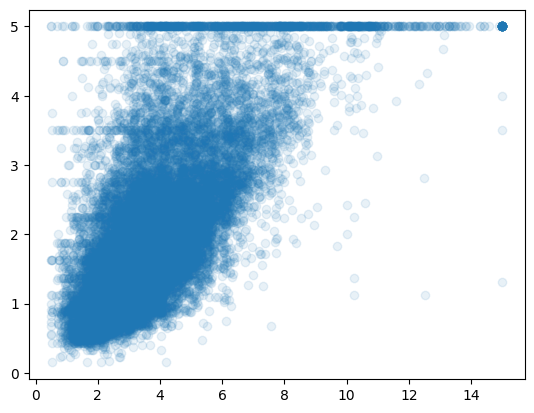

In [287]:
plt.plot( X.loc[:, 'MedInc'], housing.target, 'o', alpha=0.1)

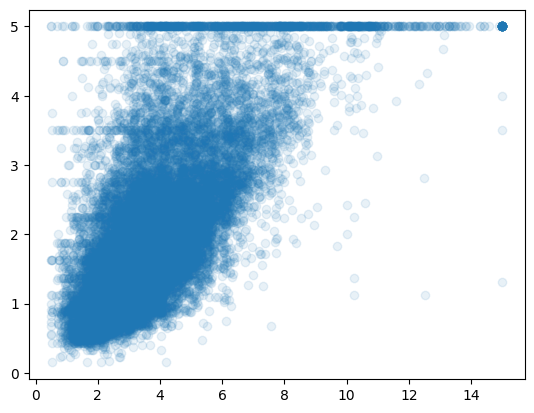

In [312]:
plt.plot( X.loc[:, 'MedInc'], housing.target, 'o', alpha=0.1)

In [313]:
import matplotlib.pyplot as plt

def scatter_grid(df, target, nrows, ncols, figsize=(16, 8), alpha=0.7):
    """
    Create a grid of scatter plots: each feature vs target.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with feature columns.
    target : array-like or Series
        Target variable (must be same length as df).
    nrows : int
        Number of subplot rows.
    ncols : int
        Number of subplot columns.
    figsize : tuple
        Size of the full figure.
    alpha : float
        Transparency of points.
    """
    import numpy as np

    feature_names = df.columns
    n_plots = nrows * ncols
    n_features = len(feature_names)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n_features:
            ax.scatter(df.iloc[:, i], target, alpha=alpha)
            ax.set_title(feature_names[i])
        else:
            ax.axis("off")  # Hide empty subplot

    fig.tight_layout()
    plt.show()


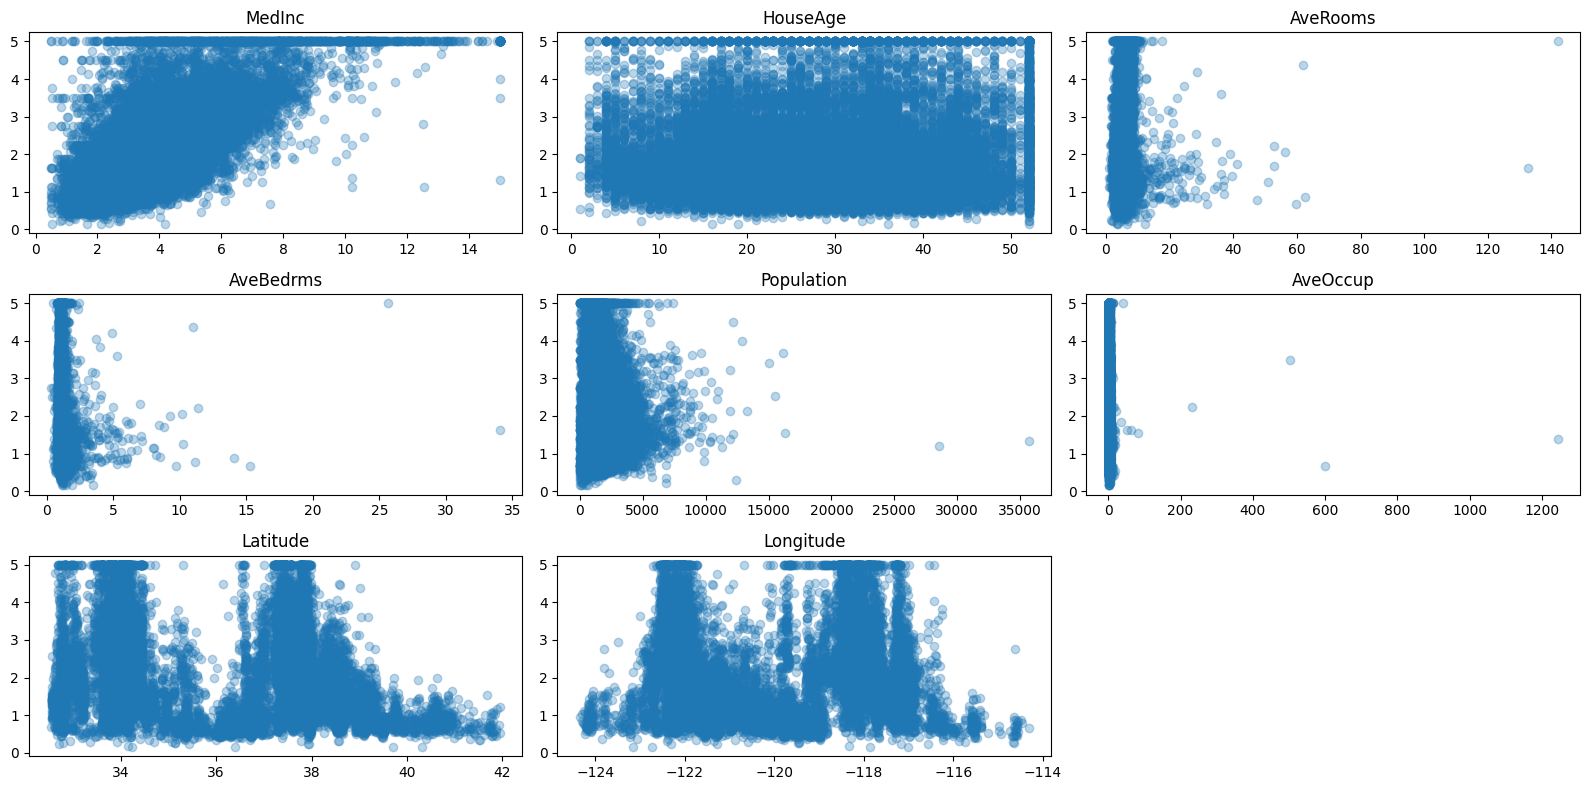

In [317]:
scatter_grid(X, housing.target, nrows=3, ncols=3, figsize=(16, 8), alpha=0.3)

In [302]:
spline = SplineTransformer(degree=1, knots = np.array([ 0, 2, 4, 6, 8, 10, 12 ]).reshape(-1, 1), include_bias=False, extrapolation='constant')

In [303]:
spline = spline.fit(X.loc[:, 'MedInc'].values.reshape(-1, 1))

In [304]:
transformed_x = spline.transform(X.loc[:, 'MedInc'].values.reshape(-1, 1))

In [ ]:
r = LinearRegression( fit_intercept=True )
r.fit( transformed_x, housing.target )

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


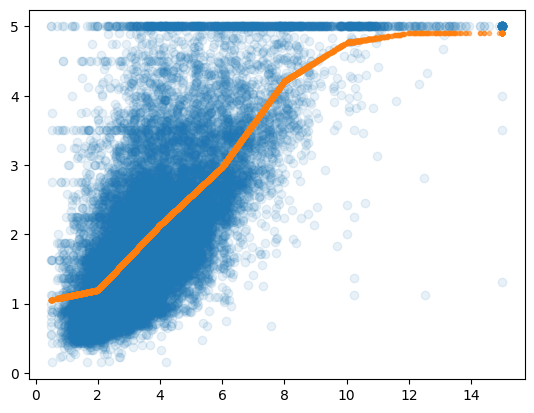

In [ ]:
plt.plot( X.loc[:, 'MedInc'], housing.target, 'o', alpha=0.1 )
plt.plot( X.loc[:, 'MedInc'], r.predict( transformed_x ), '.', alpha=0.5 )

In [55]:
dmatrix("bs(x, knots=(2,4,6,8), degree=1, include_intercept=False)", pd.DataFrame( {'x' : [1, 2, 3, 4, 5]} ))

ValueError: some knot values ([6 8]) fall above upper bound (np.int64(5))

In [15]:
from quantbullet.preprocess.transformers import FlatRampTransformer
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

In [19]:
x = np.linspace(-1, 11, 100)
y = np.sin(x) + np.random.normal(scale=0.1, size=x.shape)

In [38]:
transformer = FlatRampTransformer(knots=[0, 4, 8], include_bias=False)

In [39]:
basis = transformer.transform(x.reshape(-1, 1))

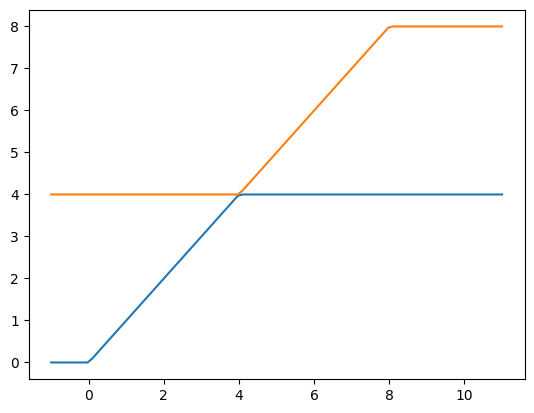

In [40]:
plt.plot( x, basis );

In [45]:
transformer = FlatRampTransformer(knots=[0, 2, 4, 6, 8, 10], include_bias=False)
basis = transformer.transform(x.reshape(-1, 1))

In [46]:
r = LinearRegression()
r.fit(basis, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [47]:
r.intercept_

np.float64(3.7631324276228235)

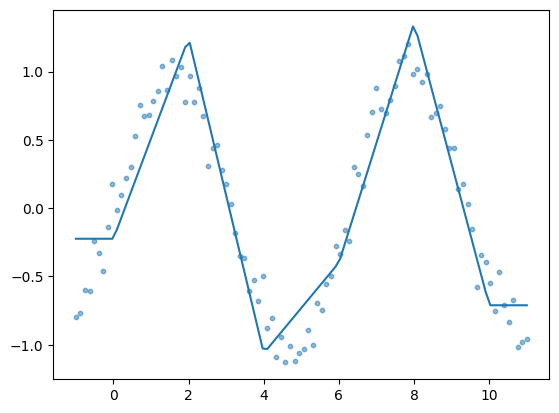

In [48]:
plt.plot(x, basis @ r.coef_.T + r.intercept_)
plt.scatter(x, y, s=10, alpha=0.5)

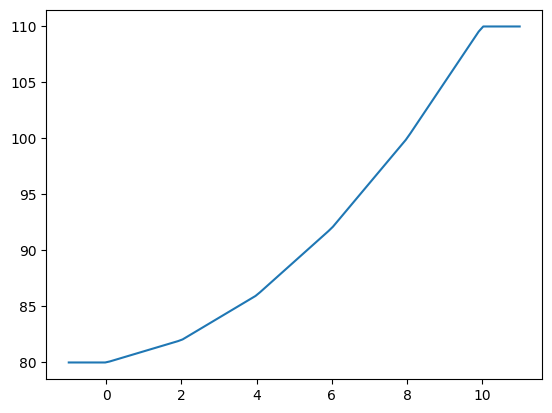

In [52]:
betas = np.array( [1, 2, 3, 4, 5] ).reshape(1, -1)
plt.plot( x, basis @ betas.T.ravel() )

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     132.6
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           5.18e-34
Time:                        10:45:55   Log-Likelihood:                -150.15
No. Observations:                 100   AIC:                             308.3
Df Residuals:                      96   BIC:                             318.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                     2.0270      0.365      5.559      0.000       1.303       2.751
bs(x, knots=(3, 7), degree=1, include_intercept=False)[0]     1.5949      0.511      3.119      0.002       0.580       2.610
bs(x, knots=(3, 7), degree=1, include_intercept=False)[1]     7.2391      0.423     17.113      0.000       6.399       8.079
bs(x, knots=(3, 7), degree=1, include_intercept=False)[2]     2.9371      0.525      5.596      0.000       1.895       3.979
==============================================================================
Omnibus:                        1.178   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.555   Jarque-Bera (JB):                1.239
Skew:                          -0.192   Prob(JB):                        0.538
Kurtosis:                       2.613   Cond. No.                         8.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

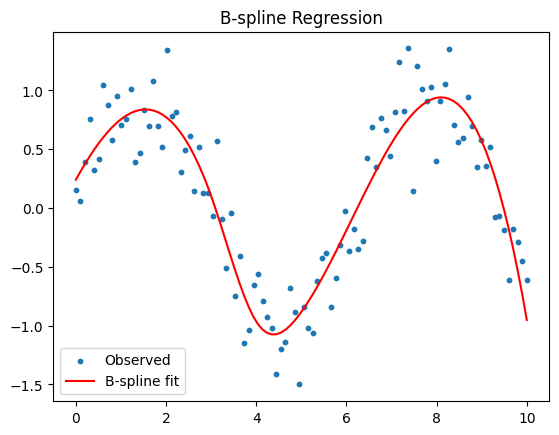

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix

# Generate data
np.random.seed(42)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(scale=0.3, size=len(x))
df = pd.DataFrame({'x': x, 'y': y})

# B-spline basis with degree=3 and 3 internal knots
spline_basis = dmatrix("bs(x, knots=(3, 4, 5), degree=3, include_intercept=True)", data=df)

# Fit a linear model to the B-spline basis
import statsmodels.api as sm
model = sm.OLS(df['y'], spline_basis).fit()
df['y_hat'] = model.predict(spline_basis)

# Plot
plt.scatter(df['x'], df['y'], label='Observed', s=10)
plt.plot(df['x'], df['y_hat'], label='B-spline fit', color='red')
plt.legend()
plt.title('B-spline Regression')
plt.show()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix
import statsmodels.api as sm

# Generate synthetic 2D data
np.random.seed(42)
x = np.random.uniform(0, 10, 200)
y = np.random.uniform(0, 10, 200)
z = np.piecewise(x, [x < 5, x >= 5], [lambda x: x, lambda x: 2*x - 5]) + \
    np.piecewise(y, [y < 5, y >= 5], [lambda y: y, lambda y: -y + 10]) + \
    np.random.normal(0, 0.5, 200)

df = pd.DataFrame({'x': x, 'y': y, 'z': z})


In [2]:
# Create piecewise linear (degree=1) tensor spline basis
X_spline = dmatrix("te(bs(x, df=6, degree=1), bs(y, df=6, degree=1))", data=df, return_type='dataframe')

# Fit linear model
model = sm.OLS(df['z'], X_spline).fit()
df['z_hat'] = model.predict(X_spline)


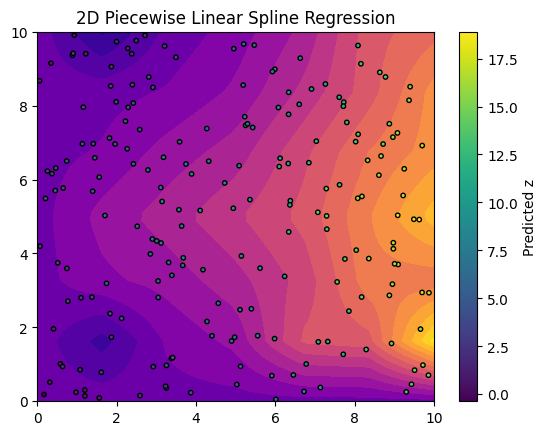

In [3]:
# Predict on a grid
x_grid = np.linspace(0, 10, 50)
y_grid = np.linspace(0, 10, 50)
Xg, Yg = np.meshgrid(x_grid, y_grid)
grid_df = pd.DataFrame({'x': Xg.ravel(), 'y': Yg.ravel()})
Xg_spline = dmatrix("te(bs(x, df=6, degree=1), bs(y, df=6, degree=1))", data=grid_df, return_type='dataframe')
grid_df['z_hat'] = model.predict(Xg_spline)

# Plot the surface
plt.contourf(Xg, Yg, grid_df['z_hat'].values.reshape(50, 50), levels=20, cmap='plasma')
plt.scatter(x, y, c=z, edgecolor='k', s=10)
plt.colorbar(label='Predicted z')
plt.title("2D Piecewise Linear Spline Regression")
plt.show()


In [4]:
%matplotlib notebook


In [5]:
from mpl_toolkits.mplot3d import Axes3D

# 1. Generate prediction grid and predicted z_hat
x_grid = np.linspace(0, 10, 50)
y_grid = np.linspace(0, 10, 50)
Xg, Yg = np.meshgrid(x_grid, y_grid)
grid_df = pd.DataFrame({'x': Xg.ravel(), 'y': Yg.ravel()})
Xg_spline = dmatrix("te(bs(x, df=6, degree=1), bs(y, df=6, degree=1))", data=grid_df, return_type='dataframe')
grid_df['z_hat'] = model.predict(Xg_spline)

# 2. Create the 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 3. Plot the spline surface
ax.plot_surface(Xg, Yg, grid_df['z_hat'].values.reshape(50, 50), alpha=0.7, cmap='plasma', edgecolor='none')

# 4. Scatter the original data points
ax.scatter(df['x'], df['y'], df['z'], c='black', s=20, label='Observed', alpha=0.8)

# 5. Axis labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z / z_hat')
ax.set_title('3D View: 2D Piecewise Linear Spline Fit + Observed Data')


plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [8]:
import plotly.graph_objects as go

# Prepare data
X_plot = Xg
Y_plot = Yg
Z_plot = grid_df['z_hat'].values.reshape(Xg.shape)

# Create 3D surface
fig = go.Figure()

fig.add_trace(go.Surface(
    x=X_plot, y=Y_plot, z=Z_plot,
    colorscale='Plasma', opacity=0.7,
    name='Fitted Surface'
))

# Add observed data points
fig.add_trace(go.Scatter3d(
    x=df['x'], y=df['y'], z=df['z'],
    mode='markers',
    marker=dict(size=4, color='black'),
    name='Observed Data'
))

fig.update_layout(
    title="3D Spline Fit + Data",
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z',
    ),
    width=800,
    height=600
)

fig.show()


In [12]:
import numpy as np
import pandas as pd
from patsy import dmatrix
from sklearn.preprocessing import SplineTransformer
import matplotlib.pyplot as plt

# Define the data points
x = np.linspace(0, 10, 100).reshape(-1, 1)
x_df = pd.DataFrame({"x": x.flatten()})

# --- Step 1: Patsy spline basis
patsy_basis = dmatrix(
    "bs(x, df=5, degree=1, include_intercept=False)", 
    x_df, 
    return_type='dataframe'
).to_numpy()

# --- Step 2: SplineTransformer (sklearn)
spline = SplineTransformer(degree=1, n_knots=7, include_bias=False, extrapolation="constant")
sklearn_basis = spline.fit_transform(x)

# --- Step 3: Tie-out check
diff = np.abs(patsy_basis - sklearn_basis)
max_diff = diff.max()

print(f"Max absolute difference between patsy and sklearn spline basis: {max_diff:.2e}")


Max absolute difference between patsy and sklearn spline basis: 1.00e+00
